# Comparação de desempenho - PFR e CSTR

O exemplo a seguir foi retirado do livro **Cinética de Reatores**, do Fogler.

<blockquote> A reação exotérmica A $\rightarrow$ B + C foi conduzida adiabaticamente e os seguintes dados foram registrados:

|        X        |  0  |  0,2 | 0,4 | 0,45 | 0,5 | 0,6 |  0,8 |  0,9 |
|:---------------:|:---:|:----:|:---:|:----:|:---:|:---:|:----:|:----:|
| **-rA (mol/L.min)** | 1,0 | 1,67 | 5,0 |  5,0 | 5,0 | 5,0 | 1,25 | 0,91 |

A vazão de entrada de A era de 300 mol/min.

a) Quais são os volumes necessários de um PFR e de um CSTR para atingir a conversão de 40%?
    
b) Qual a máxima conversão que pode ser alcançada num CSTR de 105 dm$^3$?
    
c) Plote a conversão e a velocidade de reação como uma função do volume do reator PFR, para um volume de até 100 dm$^3$.

## Primeiro passo: chamando os pacotes

Para a resolução desse problema, precisaremos de basicamente quatro pacotes:

* **Numpy**, para cálculos algébricos;
* **Matplotlib**, para plotar as resoluções;
* **scipy.integrate**, para resolução das EDOs;
* **Pandas**, para melhor organização dos resultados em DataFrame.

In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import pandas as pd

## Segundo passo: integração

Para resolver o item a), precisamos lembrar da equação de projeto de um reator PFR. O leitor deve consultar o livro para detalhes na demonstração e considerações obtidas, mas lembre-se que todas essas equações são derivadas de balanços materiais em torno do volume de controle analisado (isto é, o reator).

Para um reator PFR, a equação de projeto na forma diferencial fica:

$$F_{A0}\frac{dX}{dV} = (-r_A)$$

Vamos, então, criar um DataFrame com os dados do enunciado e definir os parâmetros:

In [3]:
FA0 = 300.0 #mol/min, vazão molar (enunciado);

data = {'Conversão': [0, 0.2, 0.4, 0.45, 0.5, 0.6, 0.8, 0.9],
       'Taxa de reação': [1.0, 1.67, 5.0, 5.0, 5.0, 5.0, 1.25, 0.91]} #Chamando os dados do enunciado.

df = pd.DataFrame(data) #Colocando os dados em DataFrame.

Reparem que, para o caso de um PFR, nós precisaríamos de uma expressão (relação) entre a taxa de reação e a conversão para conseguirmos fazer a integração numérica. Se você buscar plotar os dados fornecidos (Excel, por exemplo), não conseguirá passar nenhuma função por essa quantidade de pontos com precisão. O que precisamos, então, é fazer a **área sob a curva** formada por esses pontos (que é a definição de uma integral).

Portanto, rearranjando a equação anterior, ficamos com:

$$dV = F_{A0}\cdot\int_0^{0.4}\frac{dX}{(-r_A)}$$

Faremos essa integral usando o **método de Simpson**, já disponível no `scipy.integrate`:

In [4]:
#Pegando os valores do DataFrame até o valor de X = 40%
conversao_simps = df['Conversão'].iloc[0:3].values
taxa_simps = df['Taxa de reação'].iloc[0:3].values

#Calculando a área:

area = scipy.integrate.simps(1/taxa_simps, conversao_simps) #ATENÇÃO! A curva é X vs. 1/(-rA)!! Precisamos inverter 
                                                            #os valores para a taxa, ok??
#Resolvendo para dV:

V_PFR = area * FA0

print('O volume do PFR é de: %0.2f' % V_PFR, 'L')

O volume do PFR é de: 71.90 L


E para o CSTR? Como ficaria?

Bem, a equação de projeto para um reator CSTR é:

$$V_{CSTR} = \frac{F_{A0}\cdot X_A}{(-r_A)}$$

Resolvendo, temos:

In [5]:
V_CSTR = FA0 * 0.4 / 5.0

print('O volume do CSTR é de: %0.2f' %V_CSTR, 'L')

O volume do CSTR é de: 24.00 L


Podemos resolver o item b) agora. Ele pede a máxima conversão num CSTR se o volume for igual à 105 L. Bem, não temos o dado da taxa de reação para um volume de 105 L. As únicas informações que temos são o volume do CSTR e a vazão molar de entrada (300 mol/min). Com isso, conseguimos apenas:

$$\frac{V_{CSTR}}{F_{A0}} = \frac{X_A}{(-r_A)} \rightarrow \frac{X_A}{(-r_A)} = \frac{105 dm^3}{300 \textrm{mol/min}} = 0,35 \textrm{dm}^3\textrm{/min.mol}$$

Com os dados fornecidos, nós podemos calcular várias razões $\frac{X_A}{(-r_A)}$ e plotá-las em função da conversão.

In [6]:
df['Conv/Taxa'] = df['Conversão'].iloc[:].values / df['Taxa de reação'].iloc[:].values

#Fazendo uma regressão polinomial (grau 3) nos dados:

reg = np.polyfit(df['Conversão'], df['Conv/Taxa'], 3)

#Acessando a equação para predição de valores:

poly = np.poly1d(reg)

Agora temos um objeto `poly` que, a ele, basta adicionar o valor que quisermos de conversão e ele nos fornecerá a razão $\frac{X_A}{(-r_A)}$. O método agora é uma tentativa e erro: chutamos valores de conversão e vemos se achamos uma razão próxima de 0,35.

Mas, claro, não vamos chutar qualquer valor. Vamos olhar como ficou o nosso vetor `df['Conv/Taxa']`?

In [7]:
df

,Conversão,Taxa de reação,Conv/Taxa
0,0.00,1.00,0.000000
1,0.20,1.67,0.119760
2,0.40,5.00,0.080000
3,0.45,5.00,0.090000
4,0.50,5.00,0.100000
5,0.60,5.00,0.120000
6,0.80,1.25,0.640000
7,0.90,0.91,0.989011


Perceba que, pelos dados, a razão que procuramos está entre uma conversão de 0,6 e 0,8. Vamos chutar uma conversão de 0,65?

In [8]:
poly(0.65)

0.22690788694193276

E uma conversão de 0,7?

In [9]:
poly(0.7)

0.31764202481841913

Estamos quase lá. Talvez 0,75?

In [10]:
poly(0.75)

0.43781472195274873

Opa! Ficou maior. Então a conversão máxima é próxima de **70%**!

Finalizando nosso problema, o item C pede para que a gente plote a conversão e a taxa de reação em função do volume do reator, até 100 L. Vamos criar esse vetor para o volume:

In [11]:
V = np.arange(0.0, 100.0, 1.0)

Com os dados fornecidos no enunciado, nós conseguimos obter um volume **máximo** de PFR que corresponde à 90% de conversão. Usando o método de Simpson (área sob a curva), chegamos à um volume de PFR máximo:

In [12]:
area_max = scipy.integrate.simps(1/df['Taxa de reação'].iloc[:].values, df['Conversão'].iloc[:].values)

V_PFR_max = area_max * FA0

print('O volume máximo que um PFR realiza essa reação é %0.2f' % V_PFR_max, 'L')

O volume máximo que um PFR realiza essa reação é 138.54 L


Vamos, então, calcular o volume do PFR para todos os pontos de conversão e taxa de reação dados. Na verdade, vamos fazer a área sob a curva para cada ponto de conversão. Assim:

In [13]:
area = np.zeros(df.shape[0]-1)

#Pegando cada intervalo entre dois pontos para calcular a área sob a curva pelo método de Simpson:

for i in range(df.shape[0]-1):
    area[i] = scipy.integrate.simps(1/df['Taxa de reação'].iloc[i:i+2].values, df['Conversão'].iloc[i:i+2].values)
    
area_soma = np.cumsum(area) #Soma acumulada dos valores das áreas
V_PFR = area_soma * FA0

Agora que temos um vetor com todos os volumes, podemos plotá-lo contra a conversão:

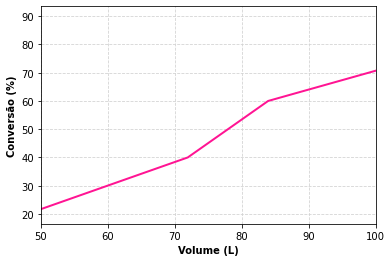

In [14]:
plt.plot(V_PFR, df['Conversão'].iloc[1:].values*100.0, linewidth = 2.0, color = 'deeppink')
plt.xlabel('Volume (L)', fontweight = 'bold')
plt.ylabel('Conversão (%)', fontweight = 'bold')
plt.xlim(50.0,100.0)
plt.grid(True, color = 'lightgray', linestyle = '--')
plt.show()

E, por fim, a taxa de reação:

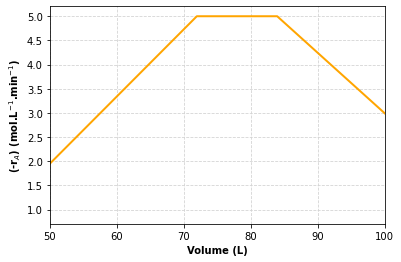

In [15]:
plt.plot(V_PFR, df['Taxa de reação'].iloc[1:].values, linewidth = 2.0, color = 'orange')
plt.xlabel('Volume (L)', fontweight = 'bold')
plt.ylabel('(-r$_A$) (mol.L$^{-1}$.min$^{-1}$)', fontweight = 'bold')
plt.xlim(50.0,100.0)
plt.grid(True, color = 'lightgray', linestyle = '--')
plt.show()